In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scri
import qnmfits

The `sxs` package doesn't have functionality to download data from the [Ext-CCE waveform catalog](https://data.black-holes.org/waveforms/extcce_catalog.html). For convenience we provide a `cce` class which downloads CCE data at the recommended extraction radius and creates an [`AsymptoticBondiData`](https://scri.readthedocs.io/en/latest/tutorial_abd.html) object.

In [2]:
# Initialize the cce class
cce = qnmfits.cce()

# We specify the ID of the simulation we want to use. This will download the 
# simulation if it is not already on your computer, and store it in 
# qnmfits/data
abd = cce.load(2)

In [3]:
# We also store useful metadata in the abd object:
Mf = abd.metadata['remnant_mass']
chif = np.linalg.norm(abd.metadata['remnant_dimensionless_spin'])

In [4]:
# The cce class provides a function to easily convert the AsymptoticBondiData
# object to a WaveformModes object
h = cce.abd_to_h(abd)

# Rescale the time so that the peak of the waveform is at t=0
h.t -= h.max_norm_time()

Text(0, 0.5, '$\\mathrm{Re}[h_{22}]$')

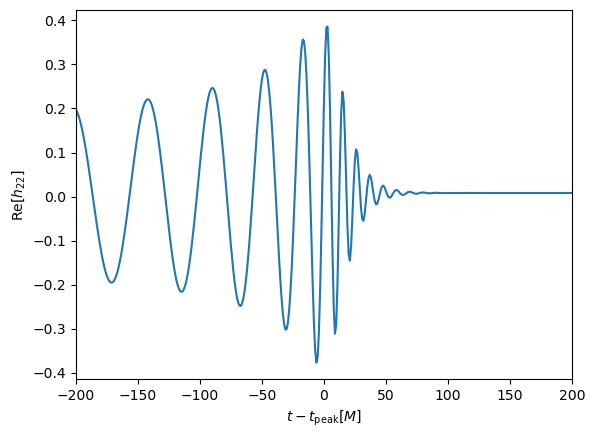

In [5]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h.data[:, h.index(2,2)]))

ax.set_xlim(-200, 200)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

### Perform a seven overtone fit to the $h_{22}$ mode at a range of different ringdown start times:

In [6]:
spherical_mode = (2,2)
qnms = [(2,2,n,1) for n in range(7+1)]

t0_array = np.linspace(-25, 25, 51)
mismatch_list = []

for t0 in t0_array:
    best_fit = qnmfits.ringdown_fit(
        h,
        spherical_mode,
        qnms,
        Mf=Mf,
        chif=chif,
        t0=t0,
        t0_method='closest'
    )
    mismatch_list.append(best_fit['mismatch'])

Text(0, 0.5, 'Mismatch, $\\mathcal{M}$')

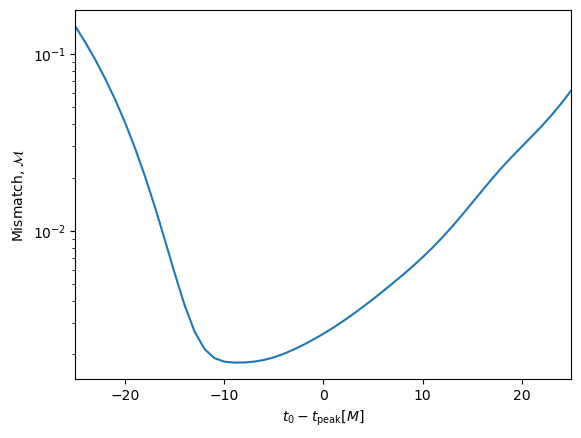

In [7]:
fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(t0_array, mismatch_list)

ax.set_xlim(t0_array[0], t0_array[-1])

ax.set_xlabel(r'$t_0 - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$')

### Map to the superrest frame

The `cce` class also has a convenience function to transform the waveform to the superrest frame of the remnant black hole, and caches the data.

In [8]:
abd_prime = cce.map_to_superrest(abd)

/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/scri/asymptotic_bondi_data/map_to_superrest_frame.py:396: RuntimeWarning: invalid value encountered in scalar divide
  np.dot(
/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/scri/asymptotic_bondi_data/map_to_superrest_frame.py:396: RuntimeWarning: invalid value encountered in scalar divide
  np.dot(
/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/scri/asymptotic_bondi_data/map_to_superrest_frame.py:396: RuntimeWarning: invalid value encountered in scalar divide
  np.dot(
/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/scri/asymptotic_bondi_data/map_to_superrest_frame.py:396: RuntimeWarning: invalid value encountered in scalar divide
  np.dot(


In [9]:
# The cce class provides a function to easily convert the AsymptoticBondiData
# object to a WaveformModes object
h_prime = cce.abd_to_h(abd_prime)

# Rescale the time so that the peak of the waveform is at t=0
h_prime.t -= h_prime.t[np.argmax(h_prime.norm())]

Text(0, 0.5, '$\\mathrm{Re}[h_{22}]$')

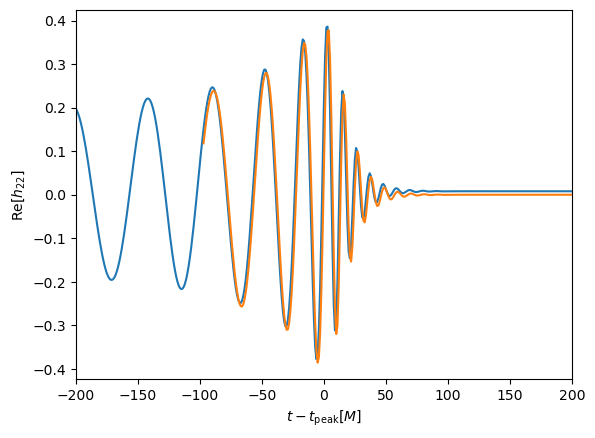

In [10]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h.data[:, h.index(2,2)]))
ax.plot(h_prime.t, np.real(h_prime.data[:, h_prime.index(2,2)]))

ax.set_xlim(-200, 200)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

In [11]:
superrest_mismatch_list = []

for t0 in t0_array:
    best_fit = qnmfits.ringdown_fit(
        h_prime,
        spherical_mode,
        qnms,
        Mf=Mf,
        chif=chif,
        t0=t0,
        t0_method='closest'
    )
    superrest_mismatch_list.append(best_fit['mismatch'])

Text(0, 0.5, 'Mismatch, $\\mathcal{M}$')

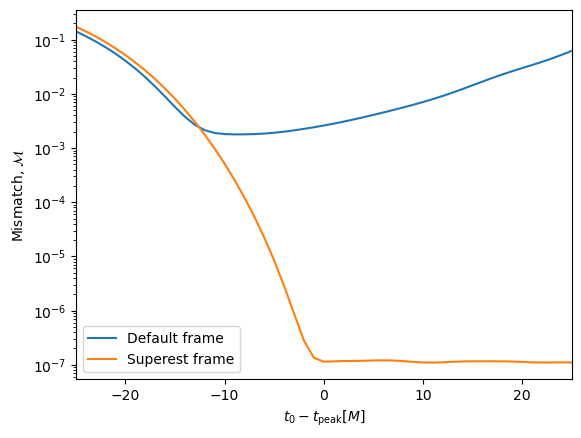

In [12]:
fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(t0_array, mismatch_list, label='Default frame')
ax.plot(t0_array, superrest_mismatch_list, label='Superest frame')

ax.set_xlim(t0_array[0], t0_array[-1])

ax.legend()

ax.set_xlabel(r'$t_0 - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$')